In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, LeakyReLU
from keras import backend as K
from keras.layers import BatchNormalization

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plot_model_history(model_history):
    history = model_history.history
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    axs[0].plot(range(1, len(history['accuracy']) + 1), history['accuracy'])
    axs[0].plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(0, len(history['accuracy']) + 1, len(history['accuracy'])/10))
    axs[0].legend(['train', 'val'], loc='best')
    
    axs[1].plot(range(1, len(history['loss']) + 1), history['loss'])
    axs[1].plot(range(1, len(history['val_loss']) + 1), history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(0, len(history['loss']) + 1, len(history['loss'])/10))
    axs[1].legend(['train', 'val'], loc='best')

    axs[2].plot(range(1, len(history['lr']) + 1), history['lr'])
    axs[2].set_title('Learning Rate')
    axs[2].set_ylabel('Learning rate')
    axs[2].set_xlabel('Epoch')
    axs[2].set_xticks(np.arange(0, len(history['lr']) + 1, len(history['lr'])/10))
    
    plt.show()

In [3]:
base_skin_dir = os.path.join('..', 'input/skin-cancer-mnist-ham10000')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [6]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [8]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

In [9]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(100, 100, 3)    10015
Name: image, dtype: int64

In [10]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [11]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,random_state=1234)

In [12]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [13]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [14]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2)

In [15]:
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 100, 3))

In [16]:
num_classes = 7
input_shape = (100, 100, 3)
model =Sequential()

model.add(Conv2D(96, kernel_size= (11,11), strides=4, activation="relu", input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=2))

model.add(Conv2D(256, kernel_size=(5,5), padding ="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=2))

model.add(Conv2D(384, kernel_size=(3,3), padding ="same", activation="relu"))

model.add(Conv2D(384, kernel_size=(3,3), padding ="same", activation="relu"))

model.add(Conv2D(256, kernel_size=(3,3), padding ="same", activation="relu"))

model.add(MaxPool2D(pool_size=(3,3), strides=2))

model.add(Flatten())

model.add(Dense(4096, 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, 'relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 256)      1024      
 hNormalization)                                                 
                                                        

In [17]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [18]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.8,
                                            min_lr=0.0001)

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

datagen.fit(x_train)

In [21]:
epochs = 50
batch_size = 32
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              ,callbacks=[learning_rate_reduction])

Epoch 1/50
200/200 [==============================] - 23s 86ms/step - loss: 1.1074 - accuracy: 0.6693 - val_loss: 1.2195 - val_accuracy: 0.6731 - lr: 0.0010
Epoch 2/50
200/200 [==============================] - 16s 79ms/step - loss: 0.9289 - accuracy: 0.6812 - val_loss: 0.8831 - val_accuracy: 0.6962 - lr: 0.0010
Epoch 3/50
200/200 [==============================] - 16s 78ms/step - loss: 0.9152 - accuracy: 0.6804 - val_loss: 0.9041 - val_accuracy: 0.6931 - lr: 0.0010
Epoch 4/50
200/200 [==============================] - 16s 81ms/step - loss: 0.8750 - accuracy: 0.6942 - val_loss: 0.8414 - val_accuracy: 0.7056 - lr: 0.0010
Epoch 5/50
200/200 [==============================] - 15s 76ms/step - loss: 0.8403 - accuracy: 0.6945 - val_loss: 0.8758 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 6/50
200/200 [==============================] - 16s 81ms/step - loss: 0.8279 - accuracy: 0.6994 - val_loss: 0.7908 - val_accuracy: 0.7205 - lr: 0.0010
Epoch 7/50
200/200 [==============================] - 16s 

In [22]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation : accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

51/51 [==============================] - 0s 6ms/step - loss: 0.6459 - accuracy: 0.7785
Validation : accuracy = 0.778540  ;  loss_v = 0.645853
Test: accuracy = 0.760359  ;  loss = 0.667583


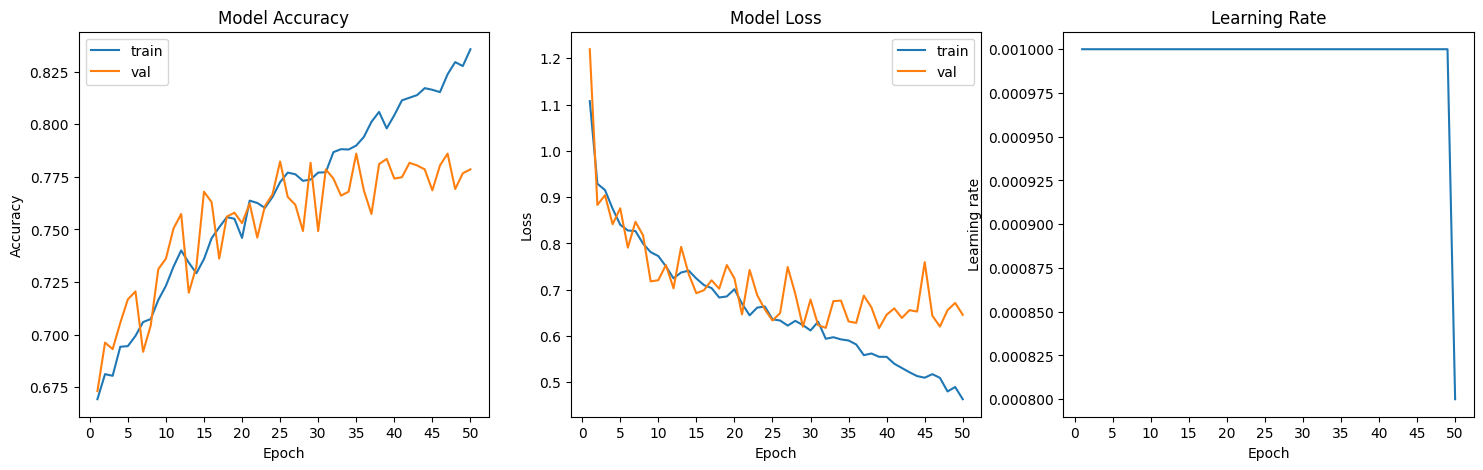

In [23]:
plot_model_history(history)

51/51 [==============================] - 0s 5ms/step


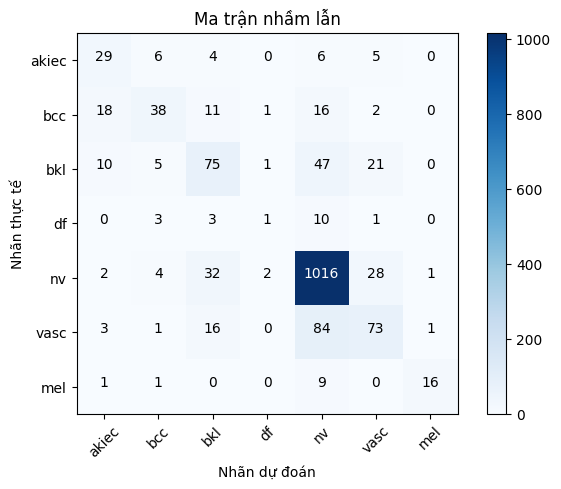

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Ma trận nhầm lẫn',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Nhãn thực tế')
    plt.xlabel('Nhãn dự đoán')

Y_pred = model.predict(x_validate) 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels) 

In [49]:
import tensorflow as tf

model_path = '/kaggle/working/model.h5'
image_path = '/kaggle/input/d/phmminhti/datatest/ung-thu-bieu-mo-te-bao-day_18.jpg'

model = tf.keras.models.load_model(model_path)

image = np.array(Image.open(image_path).resize((100, 100)))
image = (image - np.mean(image)) / np.std(image)

predictions = model.predict(np.expand_dims(image, axis=0))
out = np.argmax(predictions)

probabilities = tf.nn.softmax(predictions).numpy()
probability = probabilities[0][out] * 100

print(probability)

1/1 [==============================] - 0s 112ms/step
0.2863343
